In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
import sys,os
import rdkit
import networkx as nx
import pandas as pd

In [4]:
traintest=pd.concat([pd.read_csv("../input/train.csv",index_col=0),
                 pd.read_csv("../input/test.csv",index_col=0)]).reset_index()

/home/bo/miniconda2/envs/deepchem/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/bo/miniconda2/envs/deepchem/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [5]:
traintest.head()

id  atom_index_0  atom_index_1     molecule_name  scalar_coupling_constant  \
0   0             1             0  dsgdb9nsd_000001                   84.8076   
1   1             1             2  dsgdb9nsd_000001                  -11.2570   
2   2             1             3  dsgdb9nsd_000001                  -11.2548   
3   3             1             4  dsgdb9nsd_000001                  -11.2543   
4   4             2             0  dsgdb9nsd_000001                   84.8074   

   type  
0  1JHC  
1  2JHH  
2  2JHH  
3  2JHH  
4  1JHC

In [6]:
traintest.shape

(7163689, 6)

In [7]:
names = set(traintest['molecule_name'])
len(names)

130775

In [17]:
xyzmols={}
suppl = Chem.SDMolSupplier('../input/xyz2mol.sdf',removeHs=False)
for mol in suppl:
    name=mol.GetProp("_Name").replace(".xyz","")
    xyzmols[name]=mol
len(xyzmols)

130760

In [164]:
graphmols={}
suppl = Chem.SDMolSupplier('../input/graph2mol.sdf',removeHs=False)
for mol in suppl:
    name=mol.GetProp("_Name")
    graphmols[name]=mol
len(graphmols)

130775

In [8]:
openbabelmols={}
suppl = Chem.SDMolSupplier('../input/openbabel2mol.sdf',removeHs=False,sanitize=False) #if sanitize is true some mols is missing
for mol in suppl:
    if 1:
        name=mol.GetProp("_Name")
        openbabelmols[name]=mol
len(openbabelmols)

130775

In [9]:
def check_mol(moldict,row):
    err_msg=""
    i,j=row[['atom_index_0','atom_index_1']].values
    
    molname = row['molecule_name']
    key=(molname, i, j)
    if molname not in moldict:
        err_msg = molname+" not found"
    else:
        mol = moldict[molname] 
        
        bondtype=row['type']
        ai,aj=mol.GetAtomWithIdx(int(i)),mol.GetAtomWithIdx(int(j))
        si,sj=ai.GetSymbol(),aj.GetSymbol()
        sp = rdkit.Chem.rdmolops.GetShortestPath(mol,int(i), int(j))
        if bondtype.endswith(si+sj) or bondtype.endswith(sj+si):
            pass
        else:
            err_msg = ("atom error", row.values, si,sj)

        if int(bondtype[0])+1 == len(sp):
            pass
        else:
            err_msg =  ("bond error", row.values, sp)        
    return (key,str(err_msg))
    

# check openbabel bonds

In [10]:
from tqdm import tqdm_notebook

In [11]:
openbabelchecks={}
for i in tqdm_notebook(range(len(traintest))):
    row = traintest.iloc[i]
    key,msg = check_mol(openbabelmols,row)
    openbabelchecks[key]=msg


In [13]:
df=pd.Series(openbabelchecks).to_frame()
df=df.reset_index()
df.columns=['molname','idx0','idx1','msg']
df['has_error']=df['msg'].map(lambda u: u!="")
df.head()

molname  idx0  idx1 msg  has_error
0  dsgdb9nsd_000001     1     0          False
1  dsgdb9nsd_000001     1     2          False
2  dsgdb9nsd_000001     1     3          False
3  dsgdb9nsd_000001     1     4          False
4  dsgdb9nsd_000001     2     0          False

In [14]:
df['has_error'].sum()

0

In [144]:
df.to_csv("../input/openbabelchecks.status.csv",index=None)

In [15]:
dferror = df[df['has_error']]

In [18]:
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize=(600,400)


In [19]:
 
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

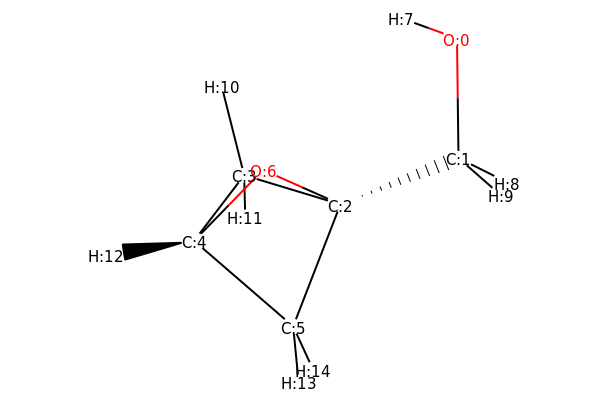

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

In [23]:
for molname in ['dsgdb9nsd_002018','dsgdb9nsd_002411','dsgdb9nsd_000699']:
    with pd.option_context('display.max_colwidth', -1):
        display(dferror[dferror['molname']==molname])
    display(mol_with_atom_index(openbabelmols[molname]))

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

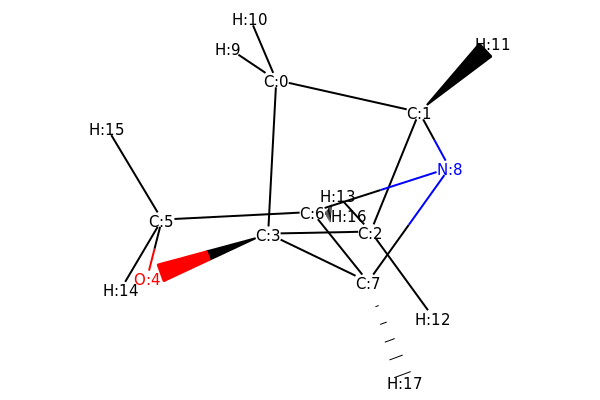

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

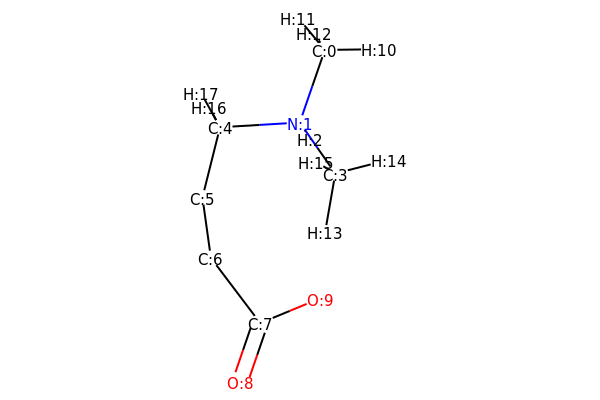

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

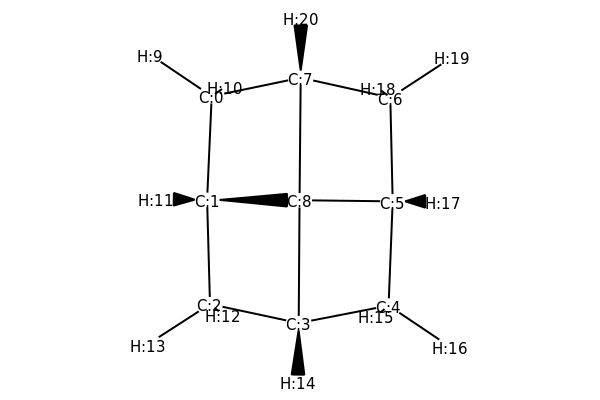

In [21]:
for molname in ['dsgdb9nsd_038230','dsgdb9nsd_059827','dsgdb9nsd_133863']:
    with pd.option_context('display.max_colwidth', -1):
        display(dferror[dferror['molname']==molname])
    display(mol_with_atom_index(openbabelmols[molname]))

# check xyz bonds

In [88]:
from tqdm import tqdm_notebook

In [89]:
xyzchecks={}
for i in tqdm_notebook(range(len(traintest))):
    row = traintest.iloc[i]
    key,msg = check_mol(xyzmols,row)
    xyzchecks[key]=msg


In [92]:
df=pd.Series(xyzchecks).to_frame()
df=df.reset_index()
df.columns=['molname','idx0','idx1','msg']
df['has_error']=df['msg'].map(lambda u: u!="")
df.head()

In [100]:
df['has_error'].sum()

650

In [144]:
df.to_csv("../input/xyzcheck.status.csv",index=None)

In [102]:
dferror = df[df['has_error']]

In [109]:
vc = dferror[dferror['msg'].map(lambda u: "not found" in u)]['molname'].value_counts()
print (vc.shape)
vc

(15,)


dsgdb9nsd_133831    70
dsgdb9nsd_037494    61
dsgdb9nsd_090191    61
dsgdb9nsd_037900    58
dsgdb9nsd_067109    50
dsgdb9nsd_090838    48
dsgdb9nsd_073323    47
dsgdb9nsd_066495    42
dsgdb9nsd_017732    38
dsgdb9nsd_107870    32
dsgdb9nsd_044308    30
dsgdb9nsd_042681    28
dsgdb9nsd_044322    27
dsgdb9nsd_048903    23
dsgdb9nsd_042676    19
Name: molname, dtype: int64

In [111]:
with pd.option_context('display.max_colwidth', -1):
    display(dferror[dferror['msg'].map(lambda u: "not found" not in u)])

molname  idx0  idx1  \
1734340  dsgdb9nsd_038230  11    6      
1734362  dsgdb9nsd_038230  14    8      
1734369  dsgdb9nsd_038230  15    8      
1734371  dsgdb9nsd_038230  16    1      
1734376  dsgdb9nsd_038230  16    8      
2878049  dsgdb9nsd_059827  2     13     
2878069  dsgdb9nsd_059827  13    0      
2878070  dsgdb9nsd_059827  13    1      
2878071  dsgdb9nsd_059827  13    3      
2878072  dsgdb9nsd_059827  13    4      
2878073  dsgdb9nsd_059827  13    14     
2878074  dsgdb9nsd_059827  13    15     
7162278  dsgdb9nsd_133863  14    7      
7162279  dsgdb9nsd_133863  14    8      
7162323  dsgdb9nsd_133863  20    3      
7162327  dsgdb9nsd_133863  20    8      

                                                                                                                                     msg  \
1734340  ('bond error', array([1129079, 11, 6, 'dsgdb9nsd_038230', 2.48513, '3JHC'], dtype=object), (11, 1, 8, 7, 6))                      
1734362  ('bond error', array([1129101, 14, 8, 'dsgdb9nsd_038230', 0.43205200000000005, '3JHN'],\n      dtype=object), (14, 5, 6, 7, 8))   
1734369  ('bond error', array([1129108, 15, 8, 'dsgdb9nsd_038230', 0.689029, '3JHN'], dtype=object), (15, 5, 6, 7, 8))                     
1734371  ('bond error', array([1129110, 16, 1, 'dsgdb9nsd_038230', 0.5600569999999999, '3JHC'],\n      dtype=object), (16, 6, 7, 8, 1))    
1734376  ('bond error', array([1129115, 16, 8, 'dsgdb9nsd_038230', 3.28913, '2JHN'], dtype=object), (16, 6, 7, 8))                         
2878049  ('bond error', array([1871375, 2, 13, 'dsgdb9nsd_059827', 2.91158, '3JHH'], dtype=object), ())                                    
2878069  ('bond error', array([1871395, 13, 0, 'dsgdb9nsd_059827', 6.13625, '3JHC'], dtype=object), ())                                    
2878070  ('bond error', array([1871396, 13, 1, 'dsgdb9nsd_059827', -0.143724, '2JHN'],\n      dtype=object), ())                           
2878071  ('bond error', array([1871397, 13, 3, 'dsgdb9nsd_059827', 111.945, '1JHC'], dtype=object), ())                                    
2878072  ('bond error', array([1871398, 13, 4, 'dsgdb9nsd_059827', 0.446191, '3JHC'], dtype=object), ())                                   
2878073  ('bond error', array([1871399, 13, 14, 'dsgdb9nsd_059827', -7.1830300000000005, '2JHH'],\n      dtype=object), ())                
2878074  ('bond error', array([1871400, 13, 15, 'dsgdb9nsd_059827', -6.73953, '2JHH'],\n      dtype=object), ())                           
7162278  ('bond error', array([7163161, 14, 7, 'dsgdb9nsd_133863', nan, '3JHC'], dtype=object), (14, 3, 2, 1, 0, 7))                       
7162279  ('bond error', array([7163162, 14, 8, 'dsgdb9nsd_133863', nan, '2JHC'], dtype=object), (14, 3, 2, 1, 8))                          
7162323  ('bond error', array([7163206, 20, 3, 'dsgdb9nsd_133863', nan, '3JHC'], dtype=object), (20, 7, 0, 1, 2, 3))                       
7162327  ('bond error', array([7163210, 20, 8, 'dsgdb9nsd_133863', nan, '2JHC'], dtype=object), (20, 7, 0, 1, 8))                          

         has_error  
1734340  True       
1734362  True       
1734369  True       
1734371  True       
1734376  True       
2878049  True       
2878069  True       
2878070  True       
2878071  True       
2878072  True       
2878073  True       
2878074  True       
7162278  True       
7162279  True       
7162323  True       
7162327  True

In [140]:
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize=(600,400)


In [141]:
 
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

molname  idx0  idx1  \
1734340  dsgdb9nsd_038230  11    6      
1734362  dsgdb9nsd_038230  14    8      
1734369  dsgdb9nsd_038230  15    8      
1734371  dsgdb9nsd_038230  16    1      
1734376  dsgdb9nsd_038230  16    8      

                                                                                                                                     msg  \
1734340  ('bond error', array([1129079, 11, 6, 'dsgdb9nsd_038230', 2.48513, '3JHC'], dtype=object), (11, 1, 8, 7, 6))                      
1734362  ('bond error', array([1129101, 14, 8, 'dsgdb9nsd_038230', 0.43205200000000005, '3JHN'],\n      dtype=object), (14, 5, 6, 7, 8))   
1734369  ('bond error', array([1129108, 15, 8, 'dsgdb9nsd_038230', 0.689029, '3JHN'], dtype=object), (15, 5, 6, 7, 8))                     
1734371  ('bond error', array([1129110, 16, 1, 'dsgdb9nsd_038230', 0.5600569999999999, '3JHC'],\n      dtype=object), (16, 6, 7, 8, 1))    
1734376  ('bond error', array([1129115, 16, 8, 'dsgdb9nsd_038230', 3.28913, '2JHN'], dtype=object), (16, 6, 7, 8))                         

         has_error  
1734340  True       
1734362  True       
1734369  True       
1734371  True       
1734376  True

molname  idx0  idx1  \
2878049  dsgdb9nsd_059827  2     13     
2878069  dsgdb9nsd_059827  13    0      
2878070  dsgdb9nsd_059827  13    1      
2878071  dsgdb9nsd_059827  13    3      
2878072  dsgdb9nsd_059827  13    4      
2878073  dsgdb9nsd_059827  13    14     
2878074  dsgdb9nsd_059827  13    15     

                                                                                                                        msg  \
2878049  ('bond error', array([1871375, 2, 13, 'dsgdb9nsd_059827', 2.91158, '3JHH'], dtype=object), ())                       
2878069  ('bond error', array([1871395, 13, 0, 'dsgdb9nsd_059827', 6.13625, '3JHC'], dtype=object), ())                       
2878070  ('bond error', array([1871396, 13, 1, 'dsgdb9nsd_059827', -0.143724, '2JHN'],\n      dtype=object), ())              
2878071  ('bond error', array([1871397, 13, 3, 'dsgdb9nsd_059827', 111.945, '1JHC'], dtype=object), ())                       
2878072  ('bond error', array([1871398, 13, 4, 'dsgdb9nsd_059827', 0.446191, '3JHC'], dtype=object), ())                      
2878073  ('bond error', array([1871399, 13, 14, 'dsgdb9nsd_059827', -7.1830300000000005, '2JHH'],\n      dtype=object), ())   
2878074  ('bond error', array([1871400, 13, 15, 'dsgdb9nsd_059827', -6.73953, '2JHH'],\n      dtype=object), ())              

         has_error  
2878049  True       
2878069  True       
2878070  True       
2878071  True       
2878072  True       
2878073  True       
2878074  True

molname  idx0  idx1  \
7162278  dsgdb9nsd_133863  14    7      
7162279  dsgdb9nsd_133863  14    8      
7162323  dsgdb9nsd_133863  20    3      
7162327  dsgdb9nsd_133863  20    8      

                                                                                                                 msg  \
7162278  ('bond error', array([7163161, 14, 7, 'dsgdb9nsd_133863', nan, '3JHC'], dtype=object), (14, 3, 2, 1, 0, 7))   
7162279  ('bond error', array([7163162, 14, 8, 'dsgdb9nsd_133863', nan, '2JHC'], dtype=object), (14, 3, 2, 1, 8))      
7162323  ('bond error', array([7163206, 20, 3, 'dsgdb9nsd_133863', nan, '3JHC'], dtype=object), (20, 7, 0, 1, 2, 3))   
7162327  ('bond error', array([7163210, 20, 8, 'dsgdb9nsd_133863', nan, '2JHC'], dtype=object), (20, 7, 0, 1, 8))      

         has_error  
7162278  True       
7162279  True       
7162323  True       
7162327  True

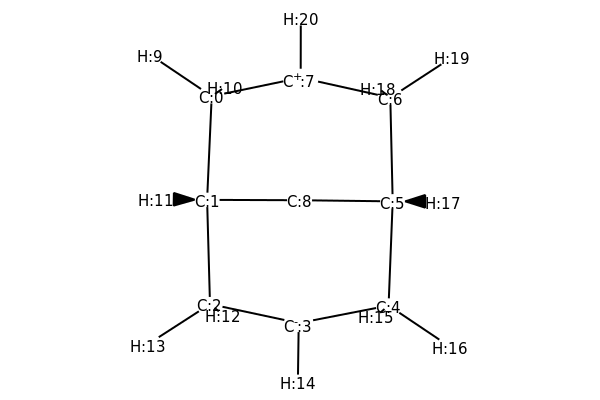

In [148]:
for molname in ['dsgdb9nsd_038230','dsgdb9nsd_059827','dsgdb9nsd_133863']:
    with pd.option_context('display.max_colwidth', -1):
        display(dferror[dferror['molname']==molname])
    display(mol_with_atom_index(xyzmols[molname]))

# check graph bonds

In [170]:
from tqdm import tqdm_notebook

In [171]:
graphchecks={}
for i in tqdm_notebook(range(len(traintest))):
    row = traintest.iloc[i]
    key,msg = check_mol(graphmols,row)
    graphchecks[key]=msg


In [172]:
df=pd.Series(graphchecks).to_frame()
df=df.reset_index()
df.columns=['molname','idx0','idx1','msg']
df['has_error']=df['msg'].map(lambda u: u!="")
df.head()

molname  idx0  idx1 msg  has_error
0  dsgdb9nsd_000001     1     0          False
1  dsgdb9nsd_000001     1     2          False
2  dsgdb9nsd_000001     1     3          False
3  dsgdb9nsd_000001     1     4          False
4  dsgdb9nsd_000001     2     0          False

In [173]:
df.shape

(7163689, 5)

In [174]:
df['has_error'].sum()

2673

In [175]:
df.to_csv("../input/graphcheck.status.csv",index=None)

In [176]:
dferror = df[df['has_error']]

In [180]:
dferror.head()

molname  idx0  idx1  \
7708  dsgdb9nsd_000271     1     4   
7709  dsgdb9nsd_000271     1     5   
7710  dsgdb9nsd_000271     1     9   
7711  dsgdb9nsd_000271     1    10   
7714  dsgdb9nsd_000271     2     4   

                                                    msg  has_error  
7708  ('bond error', array([4918, 1, 4, 'dsgdb9nsd_0...       True  
7709  ('bond error', array([4919, 1, 5, 'dsgdb9nsd_0...       True  
7710  ('bond error', array([4920, 1, 9, 'dsgdb9nsd_0...       True  
7711  ('bond error', array([4921, 1, 10, 'dsgdb9nsd_...       True  
7714  ('bond error', array([4924, 2, 4, 'dsgdb9nsd_0...       True

In [178]:
vc = dferror[dferror['msg'].map(lambda u: "not found" in u)]['molname'].value_counts()
print (vc.shape)
vc

(0,)


Series([], Name: molname, dtype: int64)

In [182]:
vc = dferror[dferror['msg'].map(lambda u: "bond error" in u)]['molname'].value_counts()
print (vc.shape)

(209,)


In [183]:
vc = dferror[dferror['msg'].map(lambda u: not "bond error" in u)]['molname'].value_counts()
print (vc.shape)

(0,)


In [179]:
with pd.option_context('display.max_colwidth', -1):
    display(dferror[dferror['msg'].map(lambda u: "not found" not in u)])

molname  idx0  idx1  \
7708     dsgdb9nsd_000271  1     4      
7709     dsgdb9nsd_000271  1     5      
7710     dsgdb9nsd_000271  1     9      
7711     dsgdb9nsd_000271  1     10     
7714     dsgdb9nsd_000271  2     4      
7715     dsgdb9nsd_000271  2     5      
7716     dsgdb9nsd_000271  2     9      
7717     dsgdb9nsd_000271  2     10     
7719     dsgdb9nsd_000271  3     4      
7720     dsgdb9nsd_000271  3     5      
7721     dsgdb9nsd_000271  3     9      
7722     dsgdb9nsd_000271  3     10     
7723     dsgdb9nsd_000271  9     0      
7730     dsgdb9nsd_000271  10    0      
7736     dsgdb9nsd_000271  11    0      
7741     dsgdb9nsd_000271  12    0      
59431    dsgdb9nsd_001670  4     1      
59432    dsgdb9nsd_001670  4     2      
59436    dsgdb9nsd_001670  4     14     
59437    dsgdb9nsd_001670  4     15     
59438    dsgdb9nsd_001670  5     1      
59439    dsgdb9nsd_001670  5     2      
59442    dsgdb9nsd_001670  5     14     
59443    dsgdb9nsd_001670  5     15     
59444    dsgdb9nsd_001670  6     1      
59445    dsgdb9nsd_001670  6     2      
59447    dsgdb9nsd_001670  6     14     
59448    dsgdb9nsd_001670  6     15     
59470    dsgdb9nsd_001670  13    3      
59477    dsgdb9nsd_001670  14    3      
...                   ...  ..   ..      
7087541  dsgdb9nsd_130454  1     4      
7087542  dsgdb9nsd_130454  1     5      
7087543  dsgdb9nsd_130454  1     12     
7087544  dsgdb9nsd_130454  1     13     
7087547  dsgdb9nsd_130454  2     4      
7087548  dsgdb9nsd_130454  2     5      
7087549  dsgdb9nsd_130454  2     12     
7087550  dsgdb9nsd_130454  2     13     
7087552  dsgdb9nsd_130454  3     4      
7087553  dsgdb9nsd_130454  3     5      
7087554  dsgdb9nsd_130454  3     12     
7087555  dsgdb9nsd_130454  3     13     
7087556  dsgdb9nsd_130454  12    0      
7087563  dsgdb9nsd_130454  13    0      
7087569  dsgdb9nsd_130454  14    0      
7087576  dsgdb9nsd_130454  15    0      
7101719  dsgdb9nsd_131200  5     2      
7101720  dsgdb9nsd_131200  5     3      
7101725  dsgdb9nsd_131200  5     11     
7101726  dsgdb9nsd_131200  5     12     
7101729  dsgdb9nsd_131200  6     2      
7101730  dsgdb9nsd_131200  6     3      
7101734  dsgdb9nsd_131200  6     11     
7101735  dsgdb9nsd_131200  6     12     
7101741  dsgdb9nsd_131200  11    4      
7101742  dsgdb9nsd_131200  11    7      
7101748  dsgdb9nsd_131200  12    4      
7101749  dsgdb9nsd_131200  12    7      
7101752  dsgdb9nsd_131200  13    3      
7101759  dsgdb9nsd_131200  14    3      

                                                                                                                                          msg  \
7708     ('bond error', array([4918, 1, 4, 'dsgdb9nsd_000271', 0.401936, '2JHC'], dtype=object), ())                                            
7709     ('bond error', array([4919, 1, 5, 'dsgdb9nsd_000271', 1.30339, '3JHC'], dtype=object), ())                                             
7710     ('bond error', array([4920, 1, 9, 'dsgdb9nsd_000271', 9.87909, '3JHH'], dtype=object), ())                                             
7711     ('bond error', array([4921, 1, 10, 'dsgdb9nsd_000271', 2.27564, '3JHH'], dtype=object), ())                                            
7714     ('bond error', array([4924, 2, 4, 'dsgdb9nsd_000271', 0.138735, '2JHC'], dtype=object), ())                                            
7715     ('bond error', array([4925, 2, 5, 'dsgdb9nsd_000271', 0.666814, '3JHC'], dtype=object), ())                                            
7716     ('bond error', array([4926, 2, 9, 'dsgdb9nsd_000271', 2.16368, '3JHH'], dtype=object), ())                                             
7717     ('bond error', array([4927, 2, 10, 'dsgdb9nsd_000271', 11.5411, '3JHH'], dtype=object), ())                                            
7719     ('bond error', array([4929, 3, 4, 'dsgdb9nsd_000271', 0.528049, '2JHC'], dtype=object), ())                                            
7720     ('bond error', a

In [184]:
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize=(600,400)


In [194]:
 
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

In [187]:
errmols= sorted(list(set(dferror['molname'])))
len(errmols)

209

In [190]:
for molname in [ 'dsgdb9nsd_038230','dsgdb9nsd_059827','dsgdb9nsd_133863']:
    print (molname, molname in errmols)

dsgdb9nsd_038230 False
dsgdb9nsd_059827 True
dsgdb9nsd_133863 False


Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

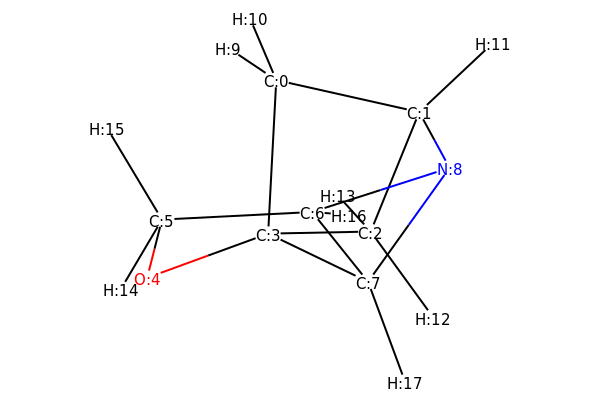

molname  idx0  idx1  \
2878044  dsgdb9nsd_059827  2     4      
2878045  dsgdb9nsd_059827  2     5      
2878052  dsgdb9nsd_059827  2     16     
2878053  dsgdb9nsd_059827  2     17     
2878057  dsgdb9nsd_059827  10    4      
2878063  dsgdb9nsd_059827  11    4      
2878068  dsgdb9nsd_059827  12    4      
2878072  dsgdb9nsd_059827  13    4      
2878078  dsgdb9nsd_059827  14    4      
2878083  dsgdb9nsd_059827  15    4      
2878084  dsgdb9nsd_059827  16    0      
2878085  dsgdb9nsd_059827  16    1      
2878086  dsgdb9nsd_059827  16    3      
2878091  dsgdb9nsd_059827  17    0      
2878092  dsgdb9nsd_059827  17    1      
2878093  dsgdb9nsd_059827  17    3      

                                                                                                                      msg  \
2878044  ('bond error', array([1871370, 2, 4, 'dsgdb9nsd_059827', -0.368813, '2JHC'], dtype=object), ())                    
2878045  ('bond error', array([1871371, 2, 5, 'dsgdb9nsd_059827', 1.32427, '3JHC'], dtype=object), ())                      
2878052  ('bond error', array([1871378, 2, 16, 'dsgdb9nsd_059827', 7.311139999999999, '3JHH'],\n      dtype=object), ())    
2878053  ('bond error', array([1871379, 2, 17, 'dsgdb9nsd_059827', 2.33478, '3JHH'], dtype=object), ())                     
2878057  ('bond error', array([1871383, 10, 4, 'dsgdb9nsd_059827', 6.913639999999999, '3JHC'],\n      dtype=object), ())    
2878063  ('bond error', array([1871389, 11, 4, 'dsgdb9nsd_059827', 1.6710900000000002, '3JHC'],\n      dtype=object), ())   
2878068  ('bond error', array([1871394, 12, 4, 'dsgdb9nsd_059827', 1.41857, '3JHC'], dtype=object), ())                     
2878072  ('bond error', array([1871398, 13, 4, 'dsgdb9nsd_059827', 0.446191, '3JHC'], dtype=object), ())                    
2878078  ('bond error', array([1871404, 14, 4, 'dsgdb9nsd_059827', 6.18856, '3JHC'], dtype=object), ())                     
2878083  ('bond error', array([1871409, 15, 4, 'dsgdb9nsd_059827', 3.4143199999999996, '3JHC'],\n      dtype=object), ())   
2878084  ('bond error', array([1871410, 16, 0, 'dsgdb9nsd_059827', 1.09445, '3JHC'], dtype=object), ())                     
2878085  ('bond error', array([1871411, 16, 1, 'dsgdb9nsd_059827', 0.233408, '2JHN'], dtype=object), ())                    
2878086  ('bond error', array([1871412, 16, 3, 'dsgdb9nsd_059827', 1.16973, '3JHC'], dtype=object), ())                     
2878091  ('bond error', array([1871417, 17, 0, 'dsgdb9nsd_059827', 0.6649229999999999, '3JHC'],\n      dtype=object), ())   
2878092  ('bond error', array([1871418, 17, 1, 'dsgdb9nsd_059827', 0.392038, '2JHN'], dtype=object), ())                    
2878093  ('bond error', array([1871419, 17, 3, 'dsgdb9nsd_059827', 3.47146, '3JHC'], dtype=object), ())                     

         has_error  
2878044  True       
2878045  True       
2878052  True       
2878053  True       
2878057  True       
2878063  True       
2878068  True       
2878072  True       
2878078  True       
2878083  True       
2878084  True       
2878085  True       
2878086  True       
2878091  True       
2878092  True       
2878093  True

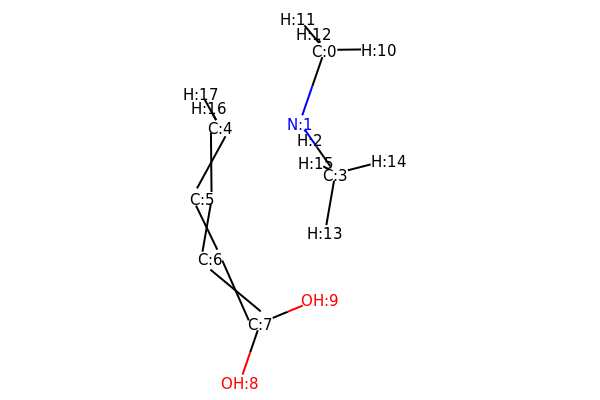

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

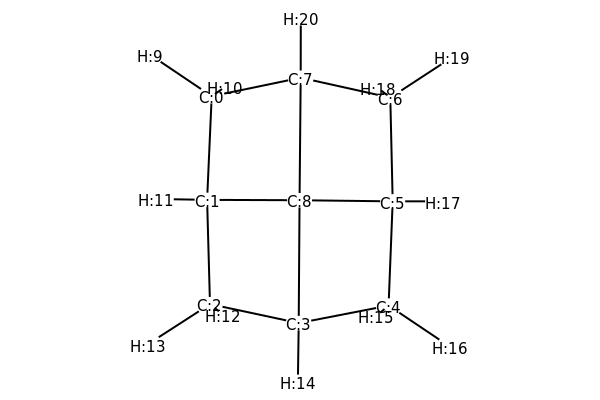

In [203]:
for molname in [  'dsgdb9nsd_038230','dsgdb9nsd_059827','dsgdb9nsd_133863']:
    with pd.option_context('display.max_colwidth', -1):
        display(dferror[dferror['molname']==molname])
    mol=graphmols[molname]
    display(mol_with_atom_index(mol))
    nx.draw(mol_to_nx(mol),with_labels=True)
    plt.show()

In [ ]:
for molname in errmols:
    with pd.option_context('display.max_colwidth', -1):
        display(dferror[dferror['molname']==molname])
    mol=graphmols[molname]
    display(mol_with_atom_index(mol))
    nx.draw(mol_to_nx(mol),with_labels=True)
    plt.show()
    